##Setting up Packages and Installation for the projects

In [2]:
#Installing kaggle API client
!pip install -q kaggle

#Installing FastAI
!pip install fastai

In [3]:
# Mounting Google Drive files
from google.colab import drive
drive.mount('/content/gdrive')

#Uploading the kaggle.json file
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alessandroea","key":"59ff2ef98f952b274456cce8323519b5"}'}

In [4]:
#kaggle API client expects the file to be in ~/.kaggle
#Moving it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
#Setting the permissions
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
#Check directory before downloading the datasets
!pwd

/content


In [7]:
#Listing all available datasets
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18641  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11312  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5809  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3977  
nickuzmenkov/nih-chest-xrays-tfrecords                      NIH Chest X-rays

In [8]:
#Downloading the required dataset from kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:02<00:00, 166MB/s]
100% 346M/346M [00:02<00:00, 168MB/s]


In [9]:
ls

gdrive/  intel-image-classification.zip  kaggle.json  sample_data/


In [10]:
#Unzipping the dataset
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [11]:
ls

gdrive/                         kaggle.json   seg_pred/  seg_train/
intel-image-classification.zip  sample_data/  seg_test/


In [12]:
#Importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random
import matplotlib.image as mpimg

##Starting the ML analysis

##Analysis of the data

In [13]:
#Structure of the path
x  = '/content/seg_train/seg_train'
path = Path(x)
path.ls()

[PosixPath('/content/seg_train/seg_train/forest'),
 PosixPath('/content/seg_train/seg_train/mountain'),
 PosixPath('/content/seg_train/seg_train/glacier'),
 PosixPath('/content/seg_train/seg_train/street'),
 PosixPath('/content/seg_train/seg_train/buildings'),
 PosixPath('/content/seg_train/seg_train/sea')]

In [14]:
#Getting Label names
data_dir = pathlib.Path(x)
folder = x
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))


#Visualising Random Images from train folder
random_image = random.sample(os.listdir(folder+'/buildings'),1)
img = mpimg.imread(folder+'/buildings' + "/"+random_image[0])

for i in class_names:
    for x in range(3):
        plt.figure()
        random_image = random.sample(os.listdir(folder+'/'+i),1)
        img = mpimg.imread(folder+'/'+i + "/"+random_image[0])
        plt.imshow(img)
        plt.title(i)
        plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

###Train Data

In [15]:
#Train Folder
train_path = '/content/seg_train/'
print("Train Folders: \n")
for folder in os.listdir(train_path + "seg_train"):
    files = glob.glob(train_path + "seg_train/" + folder +"/*.jpg") #list of paths matching a pathname pattern.
    print(f'({folder}): {len(files)} image')

Train Folders: 

(forest): 2271 image
(mountain): 2512 image
(glacier): 2404 image
(street): 2382 image
(buildings): 2191 image
(sea): 2274 image


In [16]:
#Images size in train folder

image_train_size = []
for folder in os.listdir(train_path + "seg_train"):
    files = glob.glob(train_path + "seg_train/" + folder +"/*.jpg")
    for file in files:
        img = cv2.imread(file)
        image_train_size.append(img.shape)
    
pd.Series(image_train_size).value_counts()

(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(123, 150, 3)        2
(142, 150, 3)        2
(144, 150, 3)        2
(108, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(136, 150, 3)        2
(119, 150, 3)        1
(133, 150, 3)        1
(100, 150, 3)        1
(140, 150, 3)        1
(131, 150, 3)        1
(149, 150, 3)        1
(105, 150, 3)        1
(141, 150, 3)        1
(115, 150, 3)        1
(76, 150, 3)         1
(110, 150, 3)        1
(120, 150, 3)        1
(147, 150, 3)        1
(102, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(81, 150, 3)         1
(124, 150, 3)        1
(97, 150, 3)         1
dtype: int64

###Test Data

In [17]:
#Test Folder
test_path = '/content/seg_test/'
print("Test Folders: \n")
for folder in os.listdir(test_path + "seg_test"):
    files = glob.glob(test_path + "seg_test/" + folder + "/*.jpg")
    print(f'({folder}): {len(files)} image')

Test Folders: 

(forest): 474 image
(mountain): 525 image
(glacier): 553 image
(street): 501 image
(buildings): 437 image
(sea): 510 image


In [18]:
#Images size in test folder

image_test_size = []
for folder in os.listdir(test_path + "seg_test"):
    files = glob.glob(test_path + "seg_test/" + folder + "/*.jpg")
    for file in files:
        img = cv2.imread(file)
        image_test_size.append(img.shape)
        
pd.Series(image_test_size).value_counts()

(150, 150, 3)    2993
(72, 150, 3)        1
(110, 150, 3)       1
(76, 150, 3)        1
(141, 150, 3)       1
(81, 150, 3)        1
(149, 150, 3)       1
(131, 150, 3)       1
dtype: int64

###Pred Data

In [19]:
#Pred Folder
pred_path = '/content/seg_pred/'
files = glob.glob(pred_path + "seg_pred/" + "/*.jpg")
print(f'Predection folder has: {len(files)} image')

Predection folder has: 7301 image


In [20]:
#Images size in pred folder

image_pred_size = []
files = glob.glob(pred_path + "seg_pred/" + "/*.jpg")
for file in files:
    img = cv2.imread(file)
    image_pred_size.append(img.shape)

pd.Series(image_pred_size).value_counts() 

(150, 150, 3)    7288
(100, 150, 3)       1
(124, 150, 3)       1
(133, 150, 3)       1
(139, 150, 3)       1
(112, 150, 3)       1
(129, 150, 3)       1
(374, 500, 3)       1
(144, 150, 3)       1
(108, 150, 3)       1
(126, 150, 3)       1
(143, 150, 3)       1
(149, 150, 3)       1
(131, 150, 3)       1
dtype: int64

##Creating the model

In [21]:
#Data Loading For training
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=150,
                                  num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

DataBunch is an API which help to build data pipelines for the model; it has different subclasses:
*   path: it indicates the path
*   train="." : training dataset, present in the current folder
*   valid_pct=0.2 : instruction to create a validation dataset with 20% of original data
*   size=150 : it means that the images usually have size 150x150; this is for STANDARISATION
*   ds_tfms=get_transforms() : data transformation, I use the get_transforms method (it flips images horizontally)
*   normalize(imagenet_stats) : normalise all the images I use to build the model
*   np.random.seed(40) to get the same random validation dataset everytime we run the command by specying a random seed

In [22]:
#Looking at the classes of the dataset
print(data.classes)
len(data.classes)
data.c

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


6

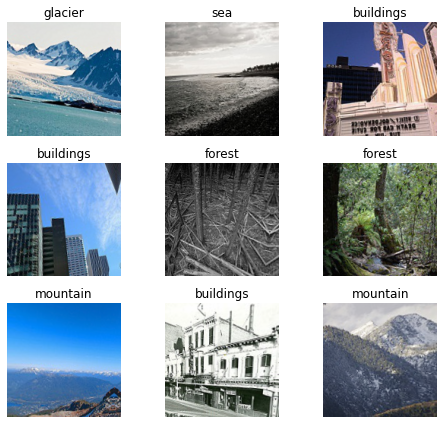

In [23]:
#Data Explorations
data.show_batch(rows=3, figsize=(7,6),recompute_scale_factor=True)

In [24]:
#Creating the Model
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], model_dir = Path('../kaggle/working'),path = Path("."))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]


This is a method of Transfer Learning to train our model; CNN learner is an API, from vision package, which is used to build the leraner object.
*   resnet18: train model architecture, which is a pretty powerful CNN model trained on ImageNet dataset
*   metrics based on accuracy



epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


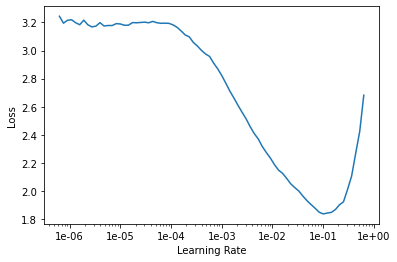

In [25]:
#Finding LR
learn.lr_find()
learn.recorder.plot(suggestions=True)



*   lr_find function : : find an optimal learning rate for our model
*   Looking at the loss vs learning rate profile
*   Select the learning rate where the loss is minimum or a rate slightly below that point






In [26]:
#Learning rate for data training
lr1 = 1e-3
lr2 = 1e-1

##Training the model

In [27]:
#Train Model - 5 epochs
learn.fit_one_cycle(5,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,0.759382,0.517491,0.873842,01:00
1,1.068143,0.564780,0.877049,00:59
2,0.620952,0.690727,0.894868,00:59
3,0.325276,0.220664,0.930150,01:00
4,0.247499,0.202642,0.935852,01:00


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


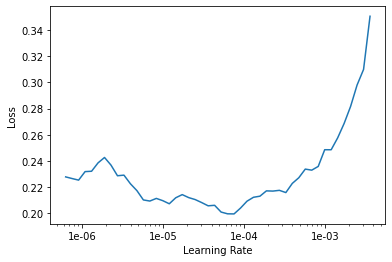

In [28]:
#Unfreeze the previous layer and check for 
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestions=True)

In [29]:
# New learning rate take from the above chart
lr3 = 1e-3
lr4 = 1e-4

In [30]:
learn.fit_one_cycle(5,slice(lr4,lr3))

epoch,train_loss,valid_loss,accuracy,time
0,0.283849,0.839754,0.909123,01:02
1,0.269658,0.296816,0.915895,01:02
2,0.230441,0.198354,0.927655,01:02
3,0.176661,0.165849,0.942267,01:02
4,0.151308,0.165422,0.945118,01:02


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


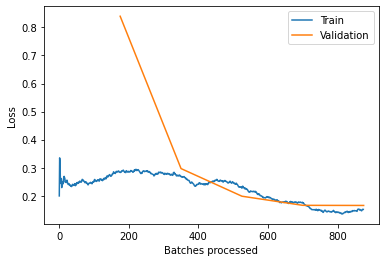

In [31]:
learn.recorder.plot_losses()

##Interpreting the results

handy tools in fast.ai library “most_confused” which basically tells us where the model found the images most confusing while training

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


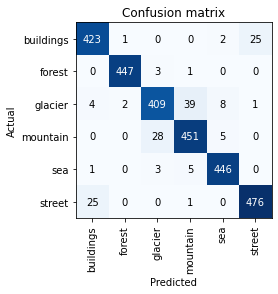

In [32]:
#Interpreting the results -1
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Handy tools in fast.ai library “most_confused” which basically tells us where the model found the images most confusing while training

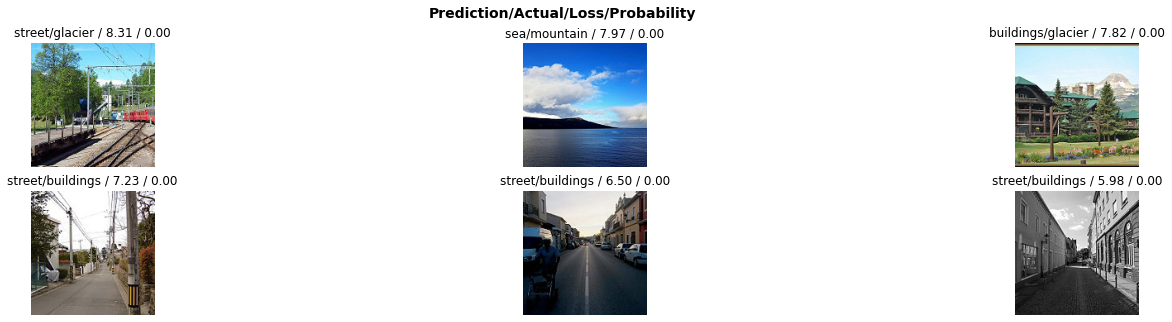

In [33]:
#Interpreting the results -1
interp.plot_top_losses(6,figsize = (25,5))

##Apply the model to predict data to predict the label of an image

In [34]:
#Taking a random file from test folder
import os, random
folder = '/content/seg_test/seg_test'
subfolder = random.choice(os.listdir(folder)) #Randomly selecting the folder
path = folder + '/' + subfolder
rnd_img = random.choice(os.listdir(path))
rnd_img_path = path + '/' + rnd_img


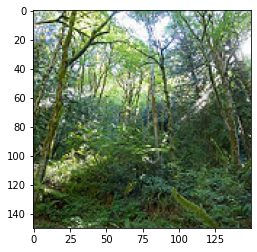

In [35]:
#Showing the picture
img = mpimg.imread(rnd_img_path)
plt.imshow(img)

In [36]:
#Making the program understand which label does the image belong to
img = open_image(rnd_img_path)
print(learn.predict(img)[0])

forest
